In [1]:
# 📌 TCN for Multi-step Sales Forecasting

In [2]:
# ===============================
# 📌 Import required libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from itertools import product

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# ===============================
# 📌 Sequence creation function
# ===============================
def create_sequences(data, window_size, output_size):
    """
    Convert a time series into supervised learning sequences.
    Args:
        data: array-like time series data.
        window_size: number of past time steps to use as input.
        output_size: number of future time steps to predict.
    Returns:
        x: input sequences of shape (num_samples, window_size).
        y: corresponding output sequences of shape (num_samples, output_size).
    """
    x, y = [], []
    for i in range(len(data) - window_size - output_size + 1):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + output_size])
    return np.array(x), np.array(y)

In [4]:
# ===============================
# 📌 Data Preparation
# ===============================
# Load dataset
df = pd.read_csv("Final dataset.csv", parse_dates=["Invoice Date"])
df.sort_values("Invoice Date", inplace=True)

# Aggregate daily sales
daily_sales = df.groupby("Invoice Date")["Sales Amount"].sum().reset_index()
daily_sales.set_index("Invoice Date", inplace=True)


# Step 1: Create sequences on raw data (before scaling)
WINDOW_SIZE = 30   # input sequence length (past 30 days)
OUTPUT_DAYS = 7    # output sequence length (predict next 7 days)
X_raw, y_raw = create_sequences(daily_sales.values, WINDOW_SIZE, OUTPUT_DAYS)

# Step 2: Train/Validation/Test split (raw values)
train_split = int(len(X_raw) * 0.7)
val_split   = int(len(X_raw) * 0.8)
y_train_raw = y_raw[:train_split]   # only use training part for fitting scaler

# Step 3: Fit scaler only on training target values
scaler = MinMaxScaler()
scaler.fit(y_train_raw.reshape(-1, 1))

# Step 4: Scale the entire dataset
daily_sales_scaled = scaler.transform(daily_sales.values)

# Step 5: Create sequences again with scaled data
X, y = create_sequences(daily_sales_scaled, WINDOW_SIZE, OUTPUT_DAYS)
X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape for Conv1D input (samples, timesteps, features)

# Step 6: Train/Validation/Test split (scaled values)
train_split = int(len(X) * 0.7)
val_split   = int(len(X) * 0.8)
X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val  : {X_val.shape}, {y_val.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

Train: (365, 30, 1), (365, 7, 1)
Val  : (52, 30, 1), (52, 7, 1)
Test : (105, 30, 1), (105, 7, 1)


In [5]:
# ===============================
# 📌 TCN-like Model Builder
# ===============================
def build_tcn(window_size, filters=64, lr=1e-3):
    """
    Build a simple Temporal Convolutional Network (TCN)-like model
    using 1D convolutions, dropout, and dense layers.
    Args:
        window_size: input sequence length.
        filters: number of convolutional filters.
        lr: learning rate for Adam optimizer.
    Returns:
        Compiled Keras model.
    """
    model = Sequential()
    # Define input explicitly
    model.add(Input(shape=(window_size, 1)))
    model.add(Conv1D(filters, kernel_size=3, padding='causal', activation='relu'))
    model.add(Conv1D(filters, kernel_size=3, padding='causal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(OUTPUT_DAYS))   # output layer
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

In [6]:
# ===============================
# 📌 Evaluation Function
# ===============================
def evaluate_on_dataset(model, X, y, scaler, dataset_name="Train"):
    """
    Evaluate a model on given dataset.
    Args:
        model: trained model.
        X: input sequences.
        y: true output sequences (scaled).
        scaler: fitted MinMaxScaler to inverse-transform predictions.
        dataset_name: label for printing results.
    Returns:
        r2, rmse, mae (evaluation metrics).
    """
    # Predict
    y_pred = model.predict(X, verbose=0)

    # Inverse transform scaled values back to original scale
    y_true_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    # Compute metrics
    r2 = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
    rmse = sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())

    print(f"{dataset_name} Evaluation:")
    print(f"  R²   = {r2:.4f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    return r2, rmse, mae

In [7]:
# ===============================
# 📌 Baseline Training
# ===============================
print("\n===== Baseline (Before Fine-tuning) =====")

# Build baseline model
baseline_model = build_tcn(WINDOW_SIZE, filters=64, lr=1e-3)

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),   # stop if no improvement
    ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)     # reduce LR if plateau
]

# Train baseline model
baseline_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=0
)

# Evaluate on Train & Validation sets (discard return values)
_ = evaluate_on_dataset(baseline_model, X_train, y_train, scaler, "Train (Baseline)")
_ = evaluate_on_dataset(baseline_model, X_val, y_val, scaler, "Validation (Baseline)")



===== Baseline (Before Fine-tuning) =====
Train (Baseline) Evaluation:
  R²   = 0.8437
  RMSE = 90950.49
  MAE  = 62825.31
Validation (Baseline) Evaluation:
  R²   = 0.7521
  RMSE = 109825.13
  MAE  = 84650.56


# 📌 Grid Search (Fine-tuning)


===== Grid Search (Fine-tuning) =====
Train Evaluation:
  R²   = 0.8241
  RMSE = 96484.64
  MAE  = 67161.17
Validation Evaluation:
  R²   = 0.6941
  RMSE = 121982.45
  MAE  = 94731.57
Train Evaluation:
  R²   = 0.8096
  RMSE = 100385.18
  MAE  = 71295.35
Validation Evaluation:
  R²   = 0.6849
  RMSE = 123810.23
  MAE  = 96871.20
Train Evaluation:
  R²   = 0.7989
  RMSE = 103167.44
  MAE  = 73082.26
Validation Evaluation:
  R²   = 0.6511
  RMSE = 130292.88
  MAE  = 98707.93
Train Evaluation:
  R²   = 0.6188
  RMSE = 142053.16
  MAE  = 107528.84
Validation Evaluation:
  R²   = 0.3913
  RMSE = 172088.14
  MAE  = 138816.78
Train Evaluation:
  R²   = 0.8905
  RMSE = 76146.40
  MAE  = 50400.34
Validation Evaluation:
  R²   = 0.9099
  RMSE = 66225.53
  MAE  = 48996.89
Train Evaluation:
  R²   = 0.8255
  RMSE = 96101.09
  MAE  = 67899.50
Validation Evaluation:
  R²   = 0.7263
  RMSE = 115391.16
  MAE  = 88173.06
Train Evaluation:
  R²   = 0.7993
  RMSE = 103081.90
  MAE  = 73815.46
Validation

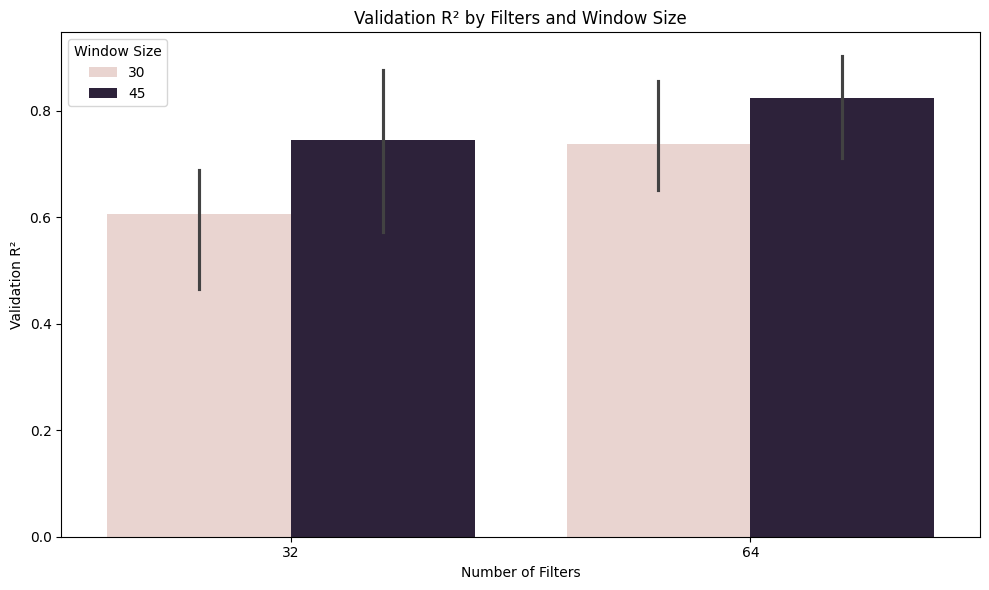

In [8]:
print("\n===== Grid Search (Fine-tuning) =====")

# Define hyperparameter search space
param_grid = {
    "window_size": [30, 45],       # input sequence length
    "filters": [32, 64],           # number of Conv1D filters
    "learning_rate": [1e-3, 5e-4], # learning rate for Adam
    "batch_size": [16, 32]         # batch size
}

# To store results
results = []
best_val_r2 = -np.inf
best_model = None
best_params = None

# Loop over all combinations of hyperparameters
for ws, f, lr, bs in product(
    param_grid["window_size"],
    param_grid["filters"],
    param_grid["learning_rate"],
    param_grid["batch_size"]
):
    # ===============================
    # 📌 Rebuild dataset for given window size
    # ===============================
    X_tmp, y_tmp = create_sequences(daily_sales_scaled, ws, OUTPUT_DAYS)
    X_tmp = X_tmp.reshape((X_tmp.shape[0], X_tmp.shape[1], 1))  # reshape for Conv1D
    train_split = int(len(X_tmp) * 0.7)
    val_split   = int(len(X_tmp) * 0.8)
    X_train_tmp, X_val_tmp = X_tmp[:train_split], X_tmp[train_split:val_split]
    y_train_tmp, y_val_tmp = y_tmp[:train_split], y_tmp[train_split:val_split]

    # ===============================
    # 📌 Build and train model
    # ===============================
    model = build_tcn(ws, f, lr)
    model.fit(
        X_train_tmp, y_train_tmp,
        epochs=50,
        batch_size=bs,
        validation_data=(X_val_tmp, y_val_tmp),
        callbacks=callbacks,
        verbose=0
    )

    # ===============================
    # 📌 Evaluate on Train & Validation sets
    # ===============================
    r2_train, rmse_train, mae_train = evaluate_on_dataset(
        model, X_train_tmp, y_train_tmp, scaler, dataset_name="Train"
    )
    r2_val, rmse_val, mae_val = evaluate_on_dataset(
        model, X_val_tmp, y_val_tmp, scaler, dataset_name="Validation"
    )

    # Save results for comparison
    results.append({
        "window_size": ws,
        "filters": f,
        "learning_rate": lr,
        "batch_size": bs,
        "Train_R2": r2_train,
        "Train_RMSE": rmse_train,
        "Train_MAE": mae_train,
        "Val_R2": r2_val,
        "Val_RMSE": rmse_val,
        "Val_MAE": mae_val
    })

    # Update best model if current config is better
    if r2_val > best_val_r2:
        best_val_r2 = r2_val
        best_model = model   # keep trained model
        best_params = {
            "window_size": ws,
            "filters": f,
            "learning_rate": lr,
            "batch_size": bs
        }

# ===============================
# 📌 Save & Summarize Results
# ===============================
results_df = pd.DataFrame(results).sort_values(by="Val_R2", ascending=False)

# Save full results
results_df.to_csv("tcn_gridsearch_results.csv", index=False)

# Show only top 5 in notebook
print("\nTop 5 Configurations:")
print(results_df.head(5).to_string(index=False))

# Show the best parameter set
print("\nBest Parameters:")
print(best_params)

# Save the best performing model
print("\nSaving best model to disk...")
best_model.save("best_tcn_model.keras")   # save in keras format


# ===============================
# 📌 Visualization of Validation R²
# ===============================
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(
    data=results_df,
    x="filters", y="Val_R2",
    hue="window_size"
)
plt.title("Validation R² by Filters and Window Size")
plt.ylabel("Validation R²")
plt.xlabel("Number of Filters")
plt.legend(title="Window Size")
plt.tight_layout()
plt.show()


# 📌 Final Test Evaluation (Best TCN)


===== Final Test Evaluation (Best TCN) =====
[Test] R²: 0.9336, RMSE: 60503.21, MAE: 40738.88, MAPE: 24.35%


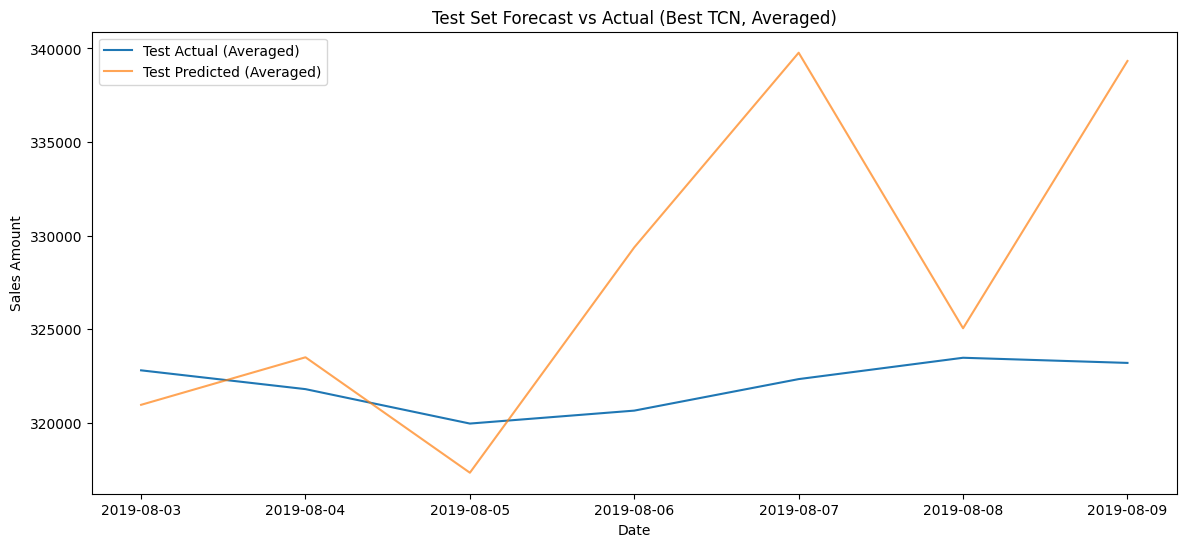

In [9]:
# Rebuild dataset using best window size
best_ws = int(best_params["window_size"])
X, y = create_sequences(daily_sales_scaled, best_ws, OUTPUT_DAYS)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train / Val / Test split
train_split = int(len(X) * 0.7)
val_split   = int(len(X) * 0.8)
X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

# ------------------------
# 📌 Evaluation Function (with MAPE)
# ------------------------
def evaluate_and_report(model, X, y, dataset_name):
    y_pred = model.predict(X, verbose=0)
    y_true_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    r2 = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
    rmse = sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())
    mape = np.mean(np.abs((y_true_inv.flatten() - y_pred_inv.flatten()) / y_true_inv.flatten())) * 100

    print(f"[{dataset_name}] R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    return {"Dataset": dataset_name, "R²": r2, "RMSE": rmse, "MAE": mae, "MAPE (%)": mape}

# ------------------------
# 📌 Evaluate Test
# ------------------------
print("\n===== Final Test Evaluation (Best TCN) =====")
results_list = []
results_list.append(evaluate_and_report(best_model, X_test, y_test, "Test"))

# ------------------------
# 📊 Plot Test Forecast vs Actual (Best TCN, Averaged)
# ------------------------
# Reshape predictions and true values back to (num_samples, OUTPUT_DAYS)
# Each row corresponds to one test sample, each column is one step in the forecast horizon
y_test_pred_seq = best_model.predict(X_test, verbose=0).reshape(-1, OUTPUT_DAYS)
y_test_true_seq = y_test.reshape(-1, OUTPUT_DAYS)

# Inverse transform back to original scale
# First flatten to 2D for scaler, then reshape back to (num_samples, OUTPUT_DAYS)
y_test_pred_seq = scaler.inverse_transform(y_test_pred_seq.reshape(-1,1)).reshape(-1, OUTPUT_DAYS)
y_test_true_seq = scaler.inverse_transform(y_test_true_seq.reshape(-1,1)).reshape(-1, OUTPUT_DAYS)

# Align overlapping predictions by averaging across all test samples
# This ensures that each day in the forecast horizon has only one averaged value
avg_pred = y_test_pred_seq.mean(axis=0)
avg_true = y_test_true_seq.mean(axis=0)

# Build date index (length = OUTPUT_DAYS) for the averaged forecast horizon
test_index_avg = pd.date_range(
    start=daily_sales.index[val_split+best_ws],  # test start date
    periods=OUTPUT_DAYS,                        # only OUTPUT_DAYS days
    freq="D"
)

# Plot averaged actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(test_index_avg, avg_true, label="Test Actual (Averaged)")
plt.plot(test_index_avg, avg_pred, label="Test Predicted (Averaged)", alpha=0.7)
plt.title("Test Set Forecast vs Actual (Best TCN, Averaged)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()



Next 7 Days Forecast (Best TCN):
        Date  Predicted Sales Amount
0 2020-01-01            320188.12500
1 2020-01-02            510268.09375
2 2020-01-03            522899.34375
3 2020-01-04            471668.59375
4 2020-01-05            567791.18750
5 2020-01-06            705725.93750
6 2020-01-07            653650.62500


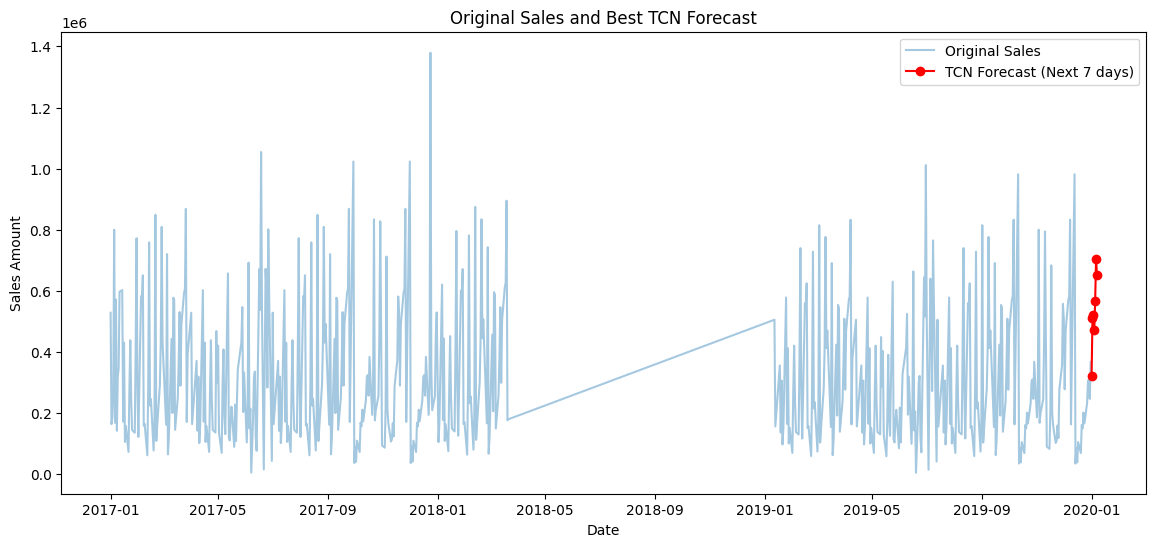

In [10]:
# ------------------------
# 📌 Forecast Next 7 Days (using best TCN model)
# ------------------------
last_input = scaler.transform(daily_sales_scaled[-best_ws:].reshape(-1, 1)).reshape(1, best_ws, 1)
future_pred_scaled = best_model.predict(last_input, verbose=0)[0]
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1))

future_dates = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Sales Amount': future_pred.flatten()})
print("\nNext 7 Days Forecast (Best TCN):")
print(forecast_df)

plt.figure(figsize=(14,6))
plt.plot(daily_sales.index, daily_sales['Sales Amount'], label="Original Sales", alpha=0.4)
plt.plot(forecast_df['Date'], forecast_df['Predicted Sales Amount'],
         marker='o', label="TCN Forecast (Next 7 days)", color="red")
plt.title("Original Sales and Best TCN Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()


In [11]:
import os
print(os.getcwd())


C:\Users\User\Documents\IA\FYP\FYP2
